<p align="center" style="font-size:24px;">
  <strong>DATA SCRAPING, DATA MODELLING DAN DATA STORING</strong><br>
  <strong>THE MOST POPULAR PERFUMES FOR WOMEN BERDASARKAN PARFUMO</strong>
</p>

<p align="center" style="font-size:22px;">
  <strong>Seleksi Tahap 2 Asisten Basdat 2024</strong><br>
  <strong>Tamara Mayranda Lubis - 18222026</strong>
</p>

#### **Import Library**

In [46]:
import requests
import json
import re
import time
import random
import mysql.connector
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from mysql.connector import Error
from bs4 import BeautifulSoup
from wordcloud import WordCloud
from collections import Counter

#### **Accessing The URL**

In [47]:
# Daftar user agents untuk mengurangi kemungkinan diblokir
user_agents = [
    'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/92.0.4515.159 Safari/537.36',
    'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/14.0.3 Safari/605.1.15',
    'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:90.0) Gecko/20100101 Firefox/90.0',
    'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:52.0) Gecko/20100101 Firefox/52.0'
]

# Header dengan user agent random
headers = {
    'User-Agent': random.choice(user_agents)
}

# URL page website yang akan di-scrape
url = 'https://www.parfumo.com/Perfumes/Tops/Women'

# Melakukan permintaan ke website
try:
    response = requests.get(url, headers=headers)
    response.raise_for_status()
except requests.RequestException as e:
    print(f"Gagal mengambil halaman: {e}")

### **DATA SCRAPING**

#### **Scrape Functions**

In [48]:
# Fungsi untuk mengambil data detail parfum
def scrape_details(detail_url):
    try:
        response = requests.get(detail_url, headers=headers)
        response.raise_for_status()
    except requests.exceptions.RequestException as e:
        print(f"Gagal melakukan permintaan: {e}")
        return {
            'Year': None,
            'Ranking': None,
            'Main Accords': None,
            'Perfumer': None,
            'Rating Value': None,
            'Rating Count': None
        }

    soup = BeautifulSoup(response.content, 'html.parser')

    # Ekstraksi tahun rilis parfum
    year_link = soup.find('a', href=lambda x: x and 'Release_Years' in x)
    year = year_link.text if year_link else None
    if year is None:
        print(f"Year tidak ditemukan: {detail_url}")

    # Ekstraksi ranking parfum
    ranking_tag = soup.find('a', class_='label_a upper pointer nowrap mb-1')
    ranking = re.search(r'\d+', ranking_tag.text).group(0) if ranking_tag else None
    if ranking is None:
        print(f"Ranking tidak ditemukan: {detail_url}")

    # Ekstraksi main accords
    accords = []
    accord_containers = soup.find_all('div', class_='s-circle-container')
    for container in accord_containers:
        accord_text = container.find('div', class_='text-xs grey')
        if accord_text:
            accords.append(accord_text.text.strip())
    if not accords:
        print(f"Main Accords tidak ditemukan: {detail_url}")

    # Ekstraksi nama pembuat parfum
    perfumer_link = soup.find('a', href=lambda x: x and 'Perfumers' in x)
    perfumer = perfumer_link.text if perfumer_link else None
    if perfumer is None:
        print(f"Perfumer tidak ditemukan: {detail_url}")

    # Ekstraksi nilai dan jumlah rating
    rating_value = soup.find('span', itemprop='ratingValue')
    rating_value = rating_value.text if rating_value else None
    rating_count = soup.find('span', itemprop='ratingCount')
    if rating_count:
        rating_count = re.search(r'\d+', rating_count.text).group(0)
    else:
        rating_count = None
    if rating_value is None or rating_count is None:
        print(f"Rating tidak ditemukan: {detail_url}")

    return {
        'Year': year,
        'Ranking': ranking,
        'Main Accords': ', '.join(accords) if accords else "Accords tidak ditemukan",
        'Perfumer': perfumer,
        'Rating Value': rating_value,
        'Rating Count': rating_count
    }

# Fungsi untuk ekstraksi dan preprocessing terhadap nama parfum
def extract_perfume_type(full_name):
    # Mendefinisikan pola untuk mengenali tipe parfum
    pattern = r"(Eau de Parfum Intense|Eau de Parfum Rouge|Eau de Parfum Poudrée|Eau de Parfum|Eau de Toilette|Extrait de Parfum|Parfum|Perfume)"
    match = re.search(pattern, full_name)
    if match:
        perfume_type = match.group(0)
        name = full_name.replace(perfume_type, '').strip()
        return perfume_type, name
    else:
        return None, full_name.strip()  # Tidak ada tipe parfum yang cocok


# Fungsi untuk ekstraksi dan preprocessing terhadap brand parfum
def extract_brand(element):
    # Mencari elemen yang berisi nama merek menggunakan BeautifulSoup
    brand_element = element.find_parent().find('span', class_='brand').find('a')
    if brand_element:
        # Mengambil teks dari elemen merek dan membersihkannya
        brand = brand_element.text.strip()
        # Memisahkan teks jika ada '/' dan mengambil bagian pertama
        brand = brand.split('/')[0].strip()
        return brand
    return None

# Fungsi untuk fetch dan process detail link parfum
def fetch_and_process_details(name_element):
    try:
        details_link = name_element['href']
        print(f'Memproses URL: {details_link}')
        return scrape_details(details_link)
    except Exception as e:
        print(f"Error saat memproses detail dari URL: {details_link}, Error: {e}")
        return None

#### **Processing All Information**

In [49]:
if response.status_code == 200:
    soup = BeautifulSoup(response.content, 'html.parser')
    perfume_elements = soup.find_all('div', class_='name')
    results = []

    for element in perfume_elements:
        name_element = element.find('a')
        if name_element:
            full_name = name_element.text.strip()
            perfume_type, name = extract_perfume_type(full_name)
            brand = extract_brand(element)
            details = fetch_and_process_details(name_element)
            if details:
                results.append({
                    'Perfume Name': name,
                    'Brand': brand,
                    'Type': perfume_type,
                    'Year': details['Year'],
                    'Ranking': details['Ranking'],
                    'Main Accords': details['Main Accords'],
                    'Perfumer': details['Perfumer'],
                    'Rating Value': details['Rating Value'],
                    'Rating Count': details['Rating Count']
                })

            # Menambahkan jeda untuk menghindari pemblokiran
            time.sleep(random.uniform(2, 5))

Memproses URL: https://www.parfumo.com/Perfumes/Guerlain/Mon_Guerlain
Memproses URL: https://www.parfumo.com/Perfumes/Dior/Hypnotic_Poison
Memproses URL: https://www.parfumo.com/Perfumes/Parfums_de_Marly/Delina
Memproses URL: https://www.parfumo.com/Perfumes/Guerlain/Shalimar
Memproses URL: https://www.parfumo.com/Perfumes/Guerlain/L_Instant_Magic
Memproses URL: https://www.parfumo.com/Perfumes/Tom_Ford/Black_Orchid_Eau_de_Parfum
Memproses URL: https://www.parfumo.com/Perfumes/Chanel/Coco_Mademoiselle
Memproses URL: https://www.parfumo.com/Perfumes/Parfums_de_Marly/Delina_Exclusif
Memproses URL: https://www.parfumo.com/Perfumes/Editions_de_Parfum_Frederic_Malle/portrait-of-a-lady-eau-de-parfum
Memproses URL: https://www.parfumo.com/Perfumes/Givenchy/l-interdit-eau-de-parfum-rouge
Memproses URL: https://www.parfumo.com/Perfumes/Narciso_Rodriguez/For_Her_Eau_de_Toilette
Memproses URL: https://www.parfumo.com/Perfumes/Amouage/Sunshine
Memproses URL: https://www.parfumo.com/Perfumes/mugler

#### **Saving to JSON File**

In [50]:
# Menyimpan hasil ke file JSON
if response.status_code == 200:
    with open('../data/100_top_women_perfumes.json', 'w', encoding='utf-8') as file:
        json.dump(results, file, ensure_ascii=False, indent=4)
    print('Data telah berhasil diekstraksi dan tersimpan ke 100_top_women_perfumes.json')
else:
    print(f'Gagal mengambil halaman. Kode status: {response.status_code}')

Data telah berhasil diekstraksi dan tersimpan ke 100_top_women_perfumes.json


### **DATA STORING**

#### **Storing Functions**

In [51]:
# Fungsi untuk membuat koneksi ke MYSQL
def create_connection(host_name, user_name, user_password, db_name):
    connection = None
    try:
        connection = mysql.connector.connect(
            host=host_name,
            user=user_name,
            passwd=user_password,
            database=db_name,
        )
        print("Koneksi ke MYSQL DB berhasil")
    except Error as e:
        print(f"Terjadi kesalahan: {e}")
    return connection

# Fungsi untuk membuat database
def create_database(connection, query):
    cursor = connection.cursor()
    try:
        cursor.execute(query)
        print("Database berhasil dibuat")
    except Error as e:
        print(f"Terjadi kesalahan: {e}")

# Funsgi untuk menjalankan query
def execute_query(connection, query, data=None):
    cursor = connection.cursor()
    try:
        if data:
            if isinstance(data, list):
                cursor.executemany(query, data)
            else:
                cursor.execute(query, data)
        else:
            cursor.execute(query)
        connection.commit()
        print("Query berhasil dijalankan")
    except Error as e:
        print(f"Terjadi kesalahan: {e}")
        cursor.close()
        return False
    cursor.close()
    return True

#### **Read the JSON File**

In [52]:
# Fungsi untuk membaca data dari file JSON
def read_json(file_path):
    """Reads JSON data from a file and returns it."""
    with open(file_path, 'r', encoding='utf-8') as file:
        data = json.load(file)
    return data

# Memanggil fungsi read_json untuk memuat data
data = read_json('../data/100_top_women_perfumes.json')

#### **Making Connection to MYSQL**

In [53]:
# Membuat koneksi ke MYSQL
connection = create_connection("localhost", "root", "Svt2605@", "")

if connection:
    # Membuat database jika belum ada
    create_database_query = "CREATE DATABASE IF NOT EXISTS 100_top_women_perfumes"
    create_database(connection, create_database_query)
    
    # Koneksi ke Database yang baru dibuat
    connection = create_connection("localhost", "root", "Svt2605@", "100_top_women_perfumes")

Koneksi ke MYSQL DB berhasil
Database berhasil dibuat
Koneksi ke MYSQL DB berhasil


#### **Creating Each Tables**

In [54]:
# Query untuk membuat tabel 'Brand'
create_brand_table = """
CREATE TABLE IF NOT EXISTS Brand (
    brand_name VARCHAR(255) PRIMARY KEY,
    country_of_origin VARCHAR(255),
    founded_year INT,
    founder VARCHAR(255)
);
"""
# Query untuk membuat tabel 'Perfumer'
create_perfumer_table = """
CREATE TABLE IF NOT EXISTS Perfumer (
    perfumer_name VARCHAR(255) PRIMARY KEY,
    date_of_birth DATE,
    nationality VARCHAR(255)
);
"""
# Query untuk membuat tabel 'Perfume'
create_perfume_table = """
CREATE TABLE IF NOT EXISTS Perfume (
    perfume_ID INT AUTO_INCREMENT PRIMARY KEY,
    perfume_name VARCHAR(255),
    brand_name VARCHAR(255),
    perfumer_name VARCHAR(255),
    type VARCHAR(255),
    release_year INT,
    price INT,
    gender ENUM('male', 'female', 'unisex'),
    bottle_size VARCHAR(100),
    rating_score DECIMAL(2, 1),
    total_rating INT,
    ranking INT,
    FOREIGN KEY (brand_name) REFERENCES Brand(brand_name),
    FOREIGN KEY (perfumer_name) REFERENCES Perfumer(perfumer_name)
);
"""
# Query untuk membuat tabel 'Perfume_Accord'
create_perfume_accord_table = """
CREATE TABLE IF NOT EXISTS Perfume_Accord (
    perfume_ID INT,
    main_accords VARCHAR(255),
    PRIMARY KEY (perfume_ID, main_accords),
    FOREIGN KEY (perfume_ID) REFERENCES Perfume(perfume_ID)
);
"""
# Query untuk membuat tabel 'Fragrance'
create_fragrance_table = """
CREATE TABLE IF NOT EXISTS Fragrance (
    fragrance_ID INT PRIMARY KEY,
    fragrance_name VARCHAR(255)
);
"""
# Query untuk membuat tabel 'Top Note'
create_top_note_table = """
CREATE TABLE IF NOT EXISTS Top_Note (
    fragrance_ID INT,
    perfume_ID INT,
    PRIMARY KEY(fragrance_ID, perfume_ID),
    FOREIGN KEY (fragrance_ID) REFERENCES Fragrance(fragrance_ID),
    FOREIGN KEY (perfume_ID) REFERENCES Perfume(perfume_ID)
);
"""
# Query untuk membuat tabel 'Heart Note'
create_heart_note_table = """
CREATE TABLE IF NOT EXISTS Heart_Note (
    fragrance_ID INT,
    perfume_ID INT,
    PRIMARY KEY(fragrance_ID, perfume_ID),
    FOREIGN KEY (fragrance_ID) REFERENCES Fragrance(fragrance_ID),
    FOREIGN KEY (perfume_ID) REFERENCES Perfume(perfume_ID)
);
"""
# Query untuk membuat tabel 'Base Note'
create_base_note_table = """
CREATE TABLE IF NOT EXISTS Base_Note (
    fragrance_ID INT,
    perfume_ID INT,
    PRIMARY KEY(fragrance_ID, perfume_ID),
    FOREIGN KEY (fragrance_ID) REFERENCES Fragrance(fragrance_ID),
    FOREIGN KEY (perfume_ID) REFERENCES Perfume(perfume_ID)
);
"""
# Query untuk membuat tabel 'User'
create_user_table = """
CREATE TABLE IF NOT EXISTS User (
    user_ID INT PRIMARY KEY,
    username VARCHAR(255),
    user_first_name VARCHAR(255),
    user_last_name VARCHAR(255),
    phone_number VARCHAR(16),
    email VARCHAR(255),
    password VARCHAR(255)
);
"""
# Query untuk membuat tabel 'Store'
create_store_table = """
CREATE TABLE IF NOT EXISTS Store (
    store_ID INT PRIMARY KEY,
    store_name VARCHAR(255),
    store_address VARCHAR(255),
    store_contact VARCHAR(255)
);
"""
# Query untuk membuat tabel 'Available'
create_available_table = """
CREATE TABLE IF NOT EXISTS Available (
    store_ID INT,
    perfume_ID INT,
    PRIMARY KEY(store_ID, perfume_ID),
    FOREIGN KEY (store_ID) REFERENCES Store(store_ID),
    FOREIGN KEY (perfume_ID) REFERENCES Perfume(perfume_ID)
);
"""
# Query untuk membuat tabel 'Review'
create_review_table = """
CREATE TABLE IF NOT EXISTS Review (
    review_ID INT,
    perfume_ID INT,
    user_ID INT,
    review TEXT,
    PRIMARY KEY(review_ID, perfume_ID, user_ID),
    FOREIGN KEY (perfume_ID) REFERENCES Perfume(perfume_ID),
    FOREIGN KEY (user_ID) REFERENCES User(user_ID)
);
"""

#### **Execute the Query**

In [55]:
create_tables = [
    create_brand_table,
    create_perfumer_table,
    create_perfume_table,
    create_perfume_accord_table,
    create_fragrance_table,
    create_top_note_table,
    create_heart_note_table,
    create_base_note_table,
    create_user_table,
    create_store_table,
    create_available_table,
    create_review_table
]

# Eksekusi semua query untuk membuat tabel
for query in create_tables:
    execute_query(connection, query)

Query berhasil dijalankan
Query berhasil dijalankan
Query berhasil dijalankan
Query berhasil dijalankan
Query berhasil dijalankan
Query berhasil dijalankan
Query berhasil dijalankan
Query berhasil dijalankan
Query berhasil dijalankan
Query berhasil dijalankan
Query berhasil dijalankan
Query berhasil dijalankan


### **Inserting the Data**

In [56]:
# Memasukkan data ke tabel Brand
brand_data = [(item['Brand'], None, None, None) for item in data if item['Brand']]
brand_query = """
INSERT INTO Brand (brand_name, country_of_origin, founded_year, founder)
VALUES (%s, %s, %s, %s)
ON DUPLICATE KEY UPDATE brand_name=VALUES(brand_name)
"""
execute_query(connection, brand_query, brand_data)

# Memasukkan data ke tabel Perfumer
perfumer_data = [(item['Perfumer'], None, None) for item in data if item['Perfumer']]
perfumer_query = """
INSERT INTO Perfumer (perfumer_name, date_of_birth, nationality)
VALUES (%s, %s, %s)
ON DUPLICATE KEY UPDATE perfumer_name=VALUES(perfumer_name)
"""
execute_query(connection, perfumer_query, perfumer_data)

# Memasukkan data ke tabel Perfume
perfume_data = [
    (
        item['Perfume Name'],
        item['Brand'],
        item['Perfumer'],
        item['Type'],
        item['Year'],
        None,
        'Female', 
        None,
        item['Rating Value'],
        item['Rating Count'],
        item['Ranking']
    )
    for item in data
]
perfume_query = """
INSERT INTO Perfume (perfume_name, brand_name, perfumer_name, type, release_year, price, gender, bottle_size, rating_score, total_rating, ranking)
VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s)
"""
execute_query(connection, perfume_query, perfume_data)

def get_perfume_id(connection, perfume_name, brand_name):
    cursor = connection.cursor(buffered=True)
    query = "SELECT perfume_ID FROM Perfume WHERE perfume_name = %s AND brand_name = %s"
    cursor.execute(query, (perfume_name, brand_name))
    result = cursor.fetchone()
    cursor.close()
    return result[0] if result else None

for item in data:
    if item['Main Accords']:
        perfume_id = get_perfume_id(connection, item['Perfume Name'], item['Brand'])
        if perfume_id:
            for accord in item['Main Accords'].split(', '):
                perfume_accord_data = (perfume_id, accord)
                perfume_accord_query = """
                INSERT INTO Perfume_Accord (perfume_ID, main_accords)
                VALUES (%s, %s)
                ON DUPLICATE KEY UPDATE main_accords=VALUES(main_accords);
                """
                execute_query(connection, perfume_accord_query, perfume_accord_data)

print('Data telah berhasil dimasukkan ke dalam database')

Query berhasil dijalankan
Query berhasil dijalankan
Query berhasil dijalankan
Query berhasil dijalankan
Query berhasil dijalankan
Query berhasil dijalankan
Query berhasil dijalankan
Query berhasil dijalankan
Query berhasil dijalankan
Query berhasil dijalankan
Query berhasil dijalankan
Query berhasil dijalankan
Query berhasil dijalankan
Query berhasil dijalankan
Query berhasil dijalankan
Query berhasil dijalankan
Query berhasil dijalankan
Query berhasil dijalankan
Query berhasil dijalankan
Query berhasil dijalankan
Query berhasil dijalankan
Query berhasil dijalankan
Query berhasil dijalankan
Query berhasil dijalankan
Query berhasil dijalankan
Query berhasil dijalankan
Query berhasil dijalankan
Query berhasil dijalankan
Query berhasil dijalankan
Query berhasil dijalankan
Query berhasil dijalankan
Query berhasil dijalankan
Query berhasil dijalankan
Query berhasil dijalankan
Query berhasil dijalankan
Query berhasil dijalankan
Query berhasil dijalankan
Query berhasil dijalankan
Query berhas

### **DATA VISUALIZATION**

#### **Top 10 Rating Parfum**

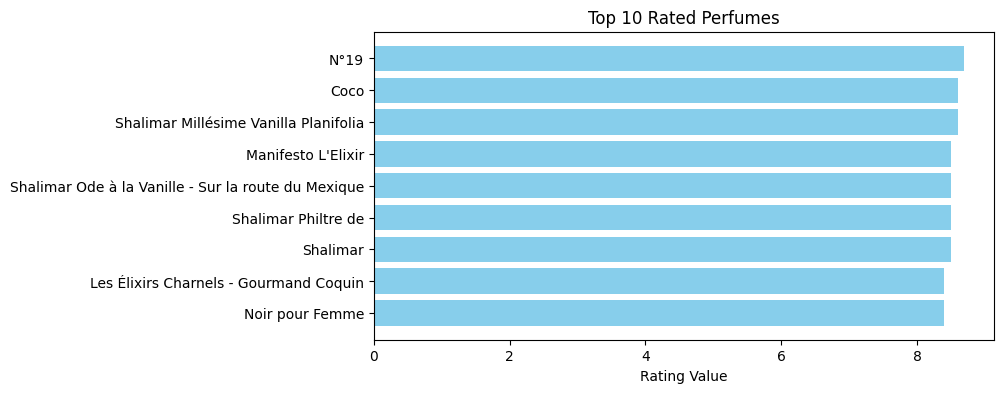

In [57]:
# Konversi data ke DataFrame
df_perfumes = pd.DataFrame(data)

df_perfumes['Rating Value'] = pd.to_numeric(df_perfumes['Rating Value'])

# Mengurutkan dan memilih 10 parfum dengan rating tertinggi
top_rated_perfumes = df_perfumes.sort_values(by='Rating Value', ascending=False).head(10)

# Membuat grafik
plt.figure(figsize=(8, 4))
plt.barh(top_rated_perfumes['Perfume Name'], top_rated_perfumes['Rating Value'], color='skyblue')
plt.xlabel('Rating Value')
plt.title('Top 10 Rated Perfumes')
plt.gca().invert_yaxis()  # Invert y-axis to show the highest rating at the top
plt.show()

Grafik di atas menunjukkan 10 parfum dengan rating yang paling tinggi. Parfum N19 merupakan parfum dengan rating tertinggi. Lalu, ada peringkat ke-10, terdapat parfum Noir pour Femme.

#### **Top 10 Frekuensi Accords dalam Parfum**

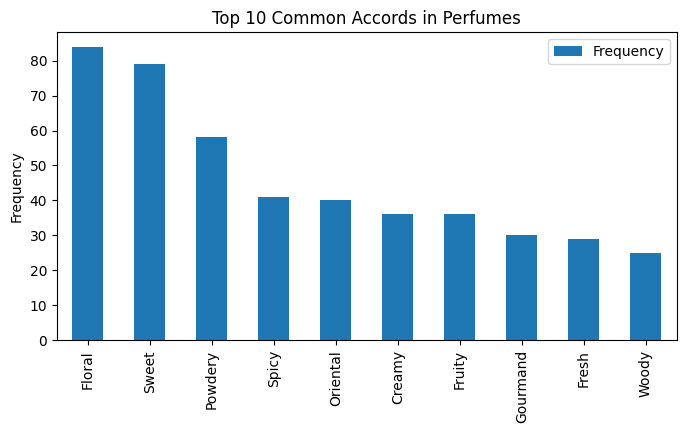

In [58]:
# Konversi data ke DataFrame
df_perfumes = pd.DataFrame(data)

# Membuat grafik
accords_list = df_perfumes['Main Accords'].str.split(', ').sum()
accord_counts = Counter(accords_list)
accord_df = pd.DataFrame.from_dict(accord_counts, orient='index', columns=['Frequency']).sort_values(by='Frequency', ascending=False)
accord_df.head(10).plot(kind='bar', figsize=(8, 4))
plt.title('Top 10 Common Accords in Perfumes')
plt.ylabel('Frequency')
plt.show()

Grafik di atas menunjukkan 10 *main accords* yang frekuensinya paling banyak di antara 100 parfum tersebut. Peringkat pertama adalah *accord floral* yang terdapat pada lebih 80 parfum. Lalu, peringkat yang ke 10 adalah *accord woody* yang terdapat pada kurang dari 30 parfum.

#### **Distribusi Tahun Rilis Parfum**

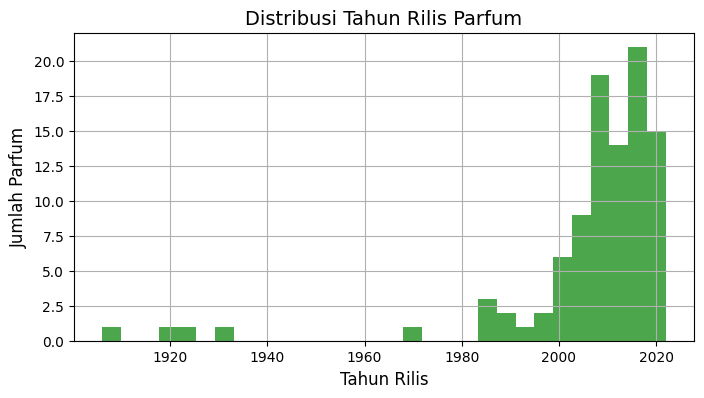

In [59]:
# Konversi data ke DataFrame
df_perfumes['Year'] = pd.to_numeric(df_perfumes['Year'], errors='coerce').dropna()

# Membuat histogram 
plt.figure(figsize=(8, 4))
plt.hist(df_perfumes['Year'], bins=30, color='green', alpha=0.7)
plt.title('Distribusi Tahun Rilis Parfum', fontsize=14)
plt.xlabel('Tahun Rilis', fontsize=12)
plt.ylabel('Jumlah Parfum', fontsize=12)
plt.grid(True)
plt.show()

Pada grafik di atas, dapat dilihat bahwa perilisan parfum didominasi pada tahun 2000 sampai tahun 2020. Parfum yang dirilis pada tahun 1940 sampai tahun 1960, tidak masuk dalam 100 *top women perfumes* oleh Parfumo.

#### **Pie-Chart Proporsi Parfum berdasarkan Perfumer** 

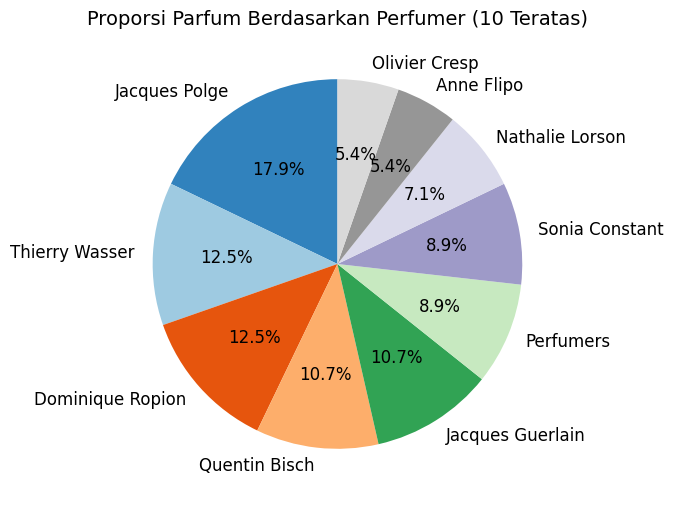

In [60]:
# Konversi data ke DataFrame
df_perfumes = pd.DataFrame(data)

# Menghitung jumlah parfum yang diciptakan oleh setiap perfumer
perfumer_counts = df_perfumes['Perfumer'].value_counts().head(10)  # Ambil 10 perfumer teratas

# Membuat Pie Chart
plt.figure(figsize=(9, 6))
colors = plt.cm.tab20c(np.linspace(0, 1, len(perfumer_counts)))  # Menggunakan NumPy untuk interpolasi warna
plt.pie(perfumer_counts, labels=perfumer_counts.index, autopct='%1.1f%%', startangle=90, colors=colors, textprops={'fontsize': 12, 'color': 'black'})
plt.title('Proporsi Parfum Berdasarkan Perfumer (10 Teratas)', fontsize=14)
plt.show()

Dari *pie-chart* di atas, dapat dilihat bahwa Jacques Polge membuat parfum terbanyak yaitu sebesar 17.9% dari 100 parfum. Lalu diikuti oleh Thierry Wasser dan Dominique Ropion dengan jumlah 12.5%. Pada peringkat ke-10, Olivier Cresp dengan persentase 5.4% dari total 100 parfum.

#### **Pie-chart Distribusi Jenis Parfum**

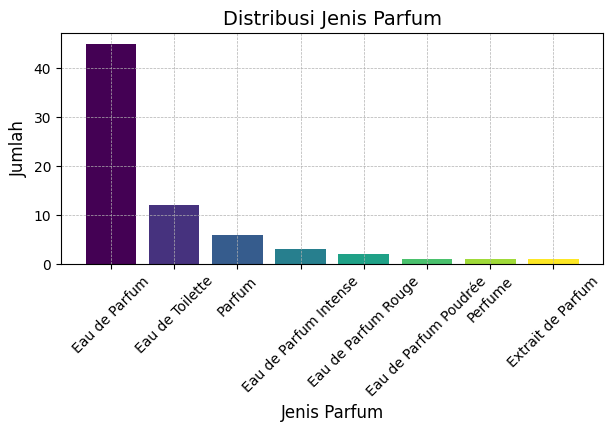

In [61]:
# Konversi data ke DataFrame
df_perfumes = pd.DataFrame(data)

# Menghitung jumlah parfum dalam setiap jenis
type_counts = df_perfumes['Type'].value_counts()

# Membuat Bar Chart untuk menampilkan distribusi jenis parfum
plt.figure(figsize=(7, 3))
plt.bar(type_counts.index, type_counts, color=plt.cm.viridis(np.linspace(0, 1, len(type_counts))))
plt.title('Distribusi Jenis Parfum', fontsize=14)
plt.xlabel('Jenis Parfum', fontsize=12)
plt.ylabel('Jumlah', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

Dari grafik di atas, dapat disimpulkan bahwa parfum dengan tipe *eau de parfum* berjumlah lebih dari 40 dan merupakan jenis parfum terbanyak dari 100 parfum yang populer di kalangan wanita berdasarkan Parfumo.